In [14]:
import pandas as pd
import numpy as np
from statsmodels.stats.inter_rater import fleiss_kappa
import simpledorff  # per Krippendorff come prima

In [15]:
file_name = "annotated_multipico_new.xlsx"
sheet_names = ['Alessandro', 'Cristina', 'Eliana', 'Michele', 'Michael', 'Elisa']
df = pd.read_excel(file_name, sheet_name=sheet_names)
df['Alessandro'].head()

,level,source,reply,post,language,language_variety,reply_id,post_id,majority_vote,Unnamed: 9,rhetorical figure,comment
0,2,twitter,@USER @USER Anche per rompere il ghiaccio,@USER Gianca già che ci sei regalale un paio d...,it,it,15902900000000000000,7961696982295378944,1,NaN,"CONTEXT SHIFT, HYPERBOLE",NaN
1,2,twitter,@USER Nonnino! Già sveglio? ??,@USER Non troppo buongiorno,it,it,4652170000000000000,4824587311292975104,1,NaN,"RHETORICAL QUESTION, HYPERBOLE",NaN
2,1,twitter,@USER il terrone di essere rimpiazzata,il terrore di essere rimpiazzata,it,it,18161900000000000000,7155693771356047360,1,NaN,"CONTEXT SHIFT, OTHER",NaN
3,1,twitter,@USER Tanto per non essere banali,"Elly #Schlein: ""Il lavoro deve tornare a esser...",it,it,5855670000000000000,5929177359346716672,1,NaN,FALSE ASSERTION,NaN
4,1,reddit,Se le toghe rosse avessere mandato un avviso d...,Se solo la società perseguisse l'obiettivo di ...,it,it,10284800000000000000,12099038560420169728,1,NaN,"OXYMORON, ANALOGY",NaN


In [16]:
# DROP colonne indesiderate subito dopo il caricamento
cols_to_drop = ['level', 'source', 'language', 'language_variety', 'majority_vote', 'Unnamed: 9', 'comment']
for name in df:
    df[name] = df[name].drop(columns=[col for col in cols_to_drop if col in df[name].columns])
df['Alessandro'].head()

,reply,post,reply_id,post_id,rhetorical figure
0,@USER @USER Anche per rompere il ghiaccio,@USER Gianca già che ci sei regalale un paio d...,15902900000000000000,7961696982295378944,"CONTEXT SHIFT, HYPERBOLE"
1,@USER Nonnino! Già sveglio? ??,@USER Non troppo buongiorno,4652170000000000000,4824587311292975104,"RHETORICAL QUESTION, HYPERBOLE"
2,@USER il terrone di essere rimpiazzata,il terrore di essere rimpiazzata,18161900000000000000,7155693771356047360,"CONTEXT SHIFT, OTHER"
3,@USER Tanto per non essere banali,"Elly #Schlein: ""Il lavoro deve tornare a esser...",5855670000000000000,5929177359346716672,FALSE ASSERTION
4,Se le toghe rosse avessere mandato un avviso d...,Se solo la società perseguisse l'obiettivo di ...,10284800000000000000,12099038560420169728,"OXYMORON, ANALOGY"


In [17]:
# Per ogni foglio, tieni solo righe con 'rhetorical figure' non-NaN
cleaned = {
    name: sheet[sheet['rhetorical figure'].notna()][['post_id', 'reply_id']]
    for name, sheet in df.items()
}

sets_of_pairs = [set(zip(sheet['post_id'], sheet['reply_id'])) for sheet in cleaned.values()]
common_pairs = set.intersection(*sets_of_pairs)
print(f"Coppie (post_id, reply_id) comuni con 'rhetorical figure' non-NaN in tutti i fogli: {len(common_pairs)}")

final_cleaned = {}
for name, sheet in df.items():
    mask = sheet.apply(lambda row: (row['post_id'], row['reply_id']) in common_pairs, axis=1)
    mask &= sheet['rhetorical figure'].notna()
    final_cleaned[name] = sheet[mask].copy()

for sheet_name in sheet_names:
    print(f"Numero di post in {sheet_name}: {len(final_cleaned[sheet_name])}")

final_cleaned['Alessandro'].head()

Coppie (post_id, reply_id) comuni con 'rhetorical figure' non-NaN in tutti i fogli: 82
Numero di post in Alessandro: 82
Numero di post in Cristina: 82
Numero di post in Eliana: 82
Numero di post in Michele: 82
Numero di post in Michael: 82
Numero di post in Elisa: 82


,reply,post,reply_id,post_id,rhetorical figure
0,@USER @USER Anche per rompere il ghiaccio,@USER Gianca già che ci sei regalale un paio d...,15902900000000000000,7961696982295378944,"CONTEXT SHIFT, HYPERBOLE"
1,@USER Nonnino! Già sveglio? ??,@USER Non troppo buongiorno,4652170000000000000,4824587311292975104,"RHETORICAL QUESTION, HYPERBOLE"
2,@USER il terrone di essere rimpiazzata,il terrore di essere rimpiazzata,18161900000000000000,7155693771356047360,"CONTEXT SHIFT, OTHER"
3,@USER Tanto per non essere banali,"Elly #Schlein: ""Il lavoro deve tornare a esser...",5855670000000000000,5929177359346716672,FALSE ASSERTION
4,Se le toghe rosse avessere mandato un avviso d...,Se solo la società perseguisse l'obiettivo di ...,10284800000000000000,12099038560420169728,"OXYMORON, ANALOGY"


In [18]:
# Estrai tutte le figure retoriche da tutti i fogli, normalizzate
all_figures_set = set()

def normalize_figures(cell):
    # Gestione NaN
    if pd.isna(cell):
        return []
    figures = [f.strip().upper() for f in str(cell).split(',')]
    # Sostituzione specifica
    figures = ["OXYMORON" if f == "OXYMORON/PARADOX" else f for f in figures]
    figures = ["EUPHEMISM" if f == "EUPHEMINSM" else f for f in figures]
    return figures

# Raccogli tutte le figure da tutti i fogli
for sheet in final_cleaned.values():
    for entry in sheet['rhetorical figure'].dropna():
        all_figures_set.update(normalize_figures(entry))

# Ordina per consistenza
all_figures = sorted(all_figures_set)

# Aggiungi una colonna per ciascuna figura: 1 se presente, 0 altrimenti
for name, sheet in final_cleaned.items():
    for fig in all_figures:
        sheet[fig] = sheet['rhetorical figure'].apply(
            lambda x: 1 if fig in normalize_figures(x) else 0
        )
    final_cleaned[name] = sheet  # Aggiorna

final_cleaned['Alessandro'].head()

,reply,post,reply_id,post_id,rhetorical figure,ANALOGY,CONTEXT SHIFT,EUPHEMISM,FALSE ASSERTION,HYPERBOLE,OTHER,OXYMORON,RHETORICAL QUESTION
0,@USER @USER Anche per rompere il ghiaccio,@USER Gianca già che ci sei regalale un paio d...,15902900000000000000,7961696982295378944,"CONTEXT SHIFT, HYPERBOLE",0,1,0,0,1,0,0,0
1,@USER Nonnino! Già sveglio? ??,@USER Non troppo buongiorno,4652170000000000000,4824587311292975104,"RHETORICAL QUESTION, HYPERBOLE",0,0,0,0,1,0,0,1
2,@USER il terrone di essere rimpiazzata,il terrore di essere rimpiazzata,18161900000000000000,7155693771356047360,"CONTEXT SHIFT, OTHER",0,1,0,0,0,1,0,0
3,@USER Tanto per non essere banali,"Elly #Schlein: ""Il lavoro deve tornare a esser...",5855670000000000000,5929177359346716672,FALSE ASSERTION,0,0,0,1,0,0,0,0
4,Se le toghe rosse avessere mandato un avviso d...,Se solo la società perseguisse l'obiettivo di ...,10284800000000000000,12099038560420169728,"OXYMORON, ANALOGY",1,0,0,0,0,0,1,0


In [19]:
def safe_krippendorff(df, class_col):
    unique_values = df[class_col].dropna().unique()
    if len(unique_values) <= 1:
        print(f"Non abbastanza variazione nei dati per calcolare Krippendorff's alpha per {class_col}")
        return None
    try:
        return simpledorff.calculate_krippendorffs_alpha_for_df(
            df,
            experiment_col='unit_id',
            annotator_col='annotator_id',
            class_col=class_col
        )
    except ZeroDivisionError:
        print(f"Divisione per zero durante il calcolo di Krippendorff's alpha per {class_col}")
        return None

def calc_alpha_for_group(final_cleaned, annotators, figures):
    print(f"\nCalcolo Krippendorff's alpha per annotatori: {annotators}")
    results = {}
    for fig in figures:
        rows = []
        for annotator in annotators:
            df_annot = final_cleaned[annotator]
            for _, row in df_annot.iterrows():
                unit_id = (row['post_id'], row['reply_id'])
                value = row[fig]
                rows.append([unit_id, annotator, value])
        df_for_alpha = pd.DataFrame(rows, columns=['unit_id', 'annotator_id', 'Annotation'])
        alpha = safe_krippendorff(df_for_alpha, 'Annotation')
        if alpha is not None:
            results[fig] = alpha
            print(f"  Figura '{fig}': alpha = {alpha:.3f}")
    if results:
        avg_alpha = sum(results.values()) / len(results)
        print(f"  Alpha medio: {avg_alpha:.3f}")
    else:
        print("  Nessun alpha calcolato correttamente.")
    return results

def calc_fleiss_for_group(final_cleaned, annotators, figures):
    print(f"\nCalcolo Fleiss' kappa per annotatori: {annotators}")
    results = {}
    for fig in figures:
        # Prepara matrice righe=unità, colonne=categorie (qui 0 o 1)
        # Costruiamo matrice (unità x categorie) con conteggi annotatori
        # Per ogni unità (post_id, reply_id) contiamo quanti annotatori hanno messo 1 e quanti 0
        
        # Primo, unisci le annotazioni di tutti gli annotatori nel gruppo
        units = set()
        data_by_annotator = {}
        for annotator in annotators:
            df_annot = final_cleaned[annotator][['post_id', 'reply_id', fig]].copy()
            df_annot['unit_id'] = list(zip(df_annot['post_id'], df_annot['reply_id']))
            data_by_annotator[annotator] = df_annot.set_index('unit_id')[fig]
            units.update(df_annot['unit_id'])
        
        units = sorted(units)
        # Costruisci la matrice di conteggi: righe=unità, colonne=[num_0, num_1]
        matrix = []
        for unit in units:
            counts = [0,0]  # [num_0, num_1]
            for annotator in annotators:
                val = data_by_annotator[annotator].get(unit, np.nan)
                if pd.isna(val):
                    # Se manca annotazione, saltiamo (non contiamo)
                    continue
                elif val == 1:
                    counts[1] += 1
                else:
                    counts[0] += 1
            # Solo includi unità con almeno un voto valido
            if sum(counts) > 0:
                matrix.append(counts)
        
        matrix = np.array(matrix)
        
        if matrix.shape[0] == 0:
            print(f"  Figura '{fig}': nessun dato valido per Fleiss' kappa")
            continue
        try:
            kappa = fleiss_kappa(matrix)
            results[fig] = kappa
            print(f"  Figura '{fig}': Fleiss' kappa = {kappa:.3f}")
        except Exception as e:
            print(f"  Figura '{fig}': errore calcolo Fleiss' kappa: {e}")
    if results:
        avg_kappa = sum(results.values()) / len(results)
        print(f"  Kappa medio: {avg_kappa:.3f}")
    else:
        print("  Nessun kappa calcolato correttamente.")
    return results

# --- Usa le funzioni ---
all_annotators = list(final_cleaned.keys())
figures = all_figures

# 1) Tutti gli annotatori insieme
print("\nCalcolo agreement tra tutti gli annotatori:")
alpha_all = calc_alpha_for_group(final_cleaned, all_annotators, figures)
kappa_all = calc_fleiss_for_group(final_cleaned, all_annotators, figures)

# 2) Coppie specifiche
print("\nCalcolo agreement tra gruppi sudivisi per generazione:")
pairs = [
    ('Alessandro', 'Cristina'),
    ('Eliana', 'Michele'),
    ('Michael', 'Elisa')
]
for pair in pairs:
    calc_alpha_for_group(final_cleaned, list(pair), figures)
    calc_fleiss_for_group(final_cleaned, list(pair), figures)

# 3) Gruppi di 3
print("\nCalcolo agreement tra gruppi suddivisi per genere:")
triplets = [
    ('Alessandro', 'Michele', 'Michael'),
    ('Cristina', 'Eliana', 'Elisa')
]
for group in triplets:
    calc_alpha_for_group(final_cleaned, list(group), figures)
    calc_fleiss_for_group(final_cleaned, list(group), figures)


Calcolo agreement tra tutti gli annotatori:

Calcolo Krippendorff's alpha per annotatori: ['Alessandro', 'Cristina', 'Eliana', 'Michele', 'Michael', 'Elisa']
  Figura 'ANALOGY': alpha = 0.254
  Figura 'CONTEXT SHIFT': alpha = 0.129
  Figura 'EUPHEMISM': alpha = 0.070
  Figura 'FALSE ASSERTION': alpha = 0.198
  Figura 'HYPERBOLE': alpha = 0.339
  Figura 'OTHER': alpha = 0.159
  Figura 'OXYMORON': alpha = 0.059
  Figura 'RHETORICAL QUESTION': alpha = 0.479
  Alpha medio: 0.211

Calcolo Fleiss' kappa per annotatori: ['Alessandro', 'Cristina', 'Eliana', 'Michele', 'Michael', 'Elisa']
  Figura 'ANALOGY': Fleiss' kappa = 0.253
  Figura 'CONTEXT SHIFT': Fleiss' kappa = 0.127
  Figura 'EUPHEMISM': Fleiss' kappa = 0.068
  Figura 'FALSE ASSERTION': Fleiss' kappa = 0.197
  Figura 'HYPERBOLE': Fleiss' kappa = 0.337
  Figura 'OTHER': Fleiss' kappa = 0.158
  Figura 'OXYMORON': Fleiss' kappa = 0.057
  Figura 'RHETORICAL QUESTION': Fleiss' kappa = 0.478
  Kappa medio: 0.209

Calcolo agreement tra gru

In [20]:
def count_figures_per_annotator(final_cleaned, annotators, figures):
    print("\nConteggio figure retoriche per annotatore:")
    counts = {}
    for annotator in annotators:
        counts[annotator] = {}
        df = final_cleaned[annotator]
        for fig in figures:
            counts[annotator][fig] = df[fig].sum()
        print(f"Annotatore {annotator}:")
        for fig, count in counts[annotator].items():
            print(f"  {fig}: {count}")
    return counts

# Usa la funzione
counts = count_figures_per_annotator(final_cleaned, all_annotators, figures)



Conteggio figure retoriche per annotatore:
Annotatore Alessandro:
  ANALOGY: 25
  CONTEXT SHIFT: 23
  EUPHEMISM: 22
  FALSE ASSERTION: 21
  HYPERBOLE: 20
  OTHER: 16
  OXYMORON: 3
  RHETORICAL QUESTION: 20
Annotatore Cristina:
  ANALOGY: 2
  CONTEXT SHIFT: 33
  EUPHEMISM: 22
  FALSE ASSERTION: 1
  HYPERBOLE: 12
  OTHER: 12
  OXYMORON: 12
  RHETORICAL QUESTION: 17
Annotatore Eliana:
  ANALOGY: 12
  CONTEXT SHIFT: 18
  EUPHEMISM: 4
  FALSE ASSERTION: 13
  HYPERBOLE: 10
  OTHER: 20
  OXYMORON: 5
  RHETORICAL QUESTION: 22
Annotatore Michele:
  ANALOGY: 3
  CONTEXT SHIFT: 10
  EUPHEMISM: 1
  FALSE ASSERTION: 16
  HYPERBOLE: 12
  OTHER: 29
  OXYMORON: 18
  RHETORICAL QUESTION: 10
Annotatore Michael:
  ANALOGY: 10
  CONTEXT SHIFT: 9
  EUPHEMISM: 12
  FALSE ASSERTION: 20
  HYPERBOLE: 17
  OTHER: 19
  OXYMORON: 3
  RHETORICAL QUESTION: 17
Annotatore Elisa:
  ANALOGY: 12
  CONTEXT SHIFT: 18
  EUPHEMISM: 0
  FALSE ASSERTION: 29
  HYPERBOLE: 14
  OTHER: 7
  OXYMORON: 2
  RHETORICAL QUESTION: 7


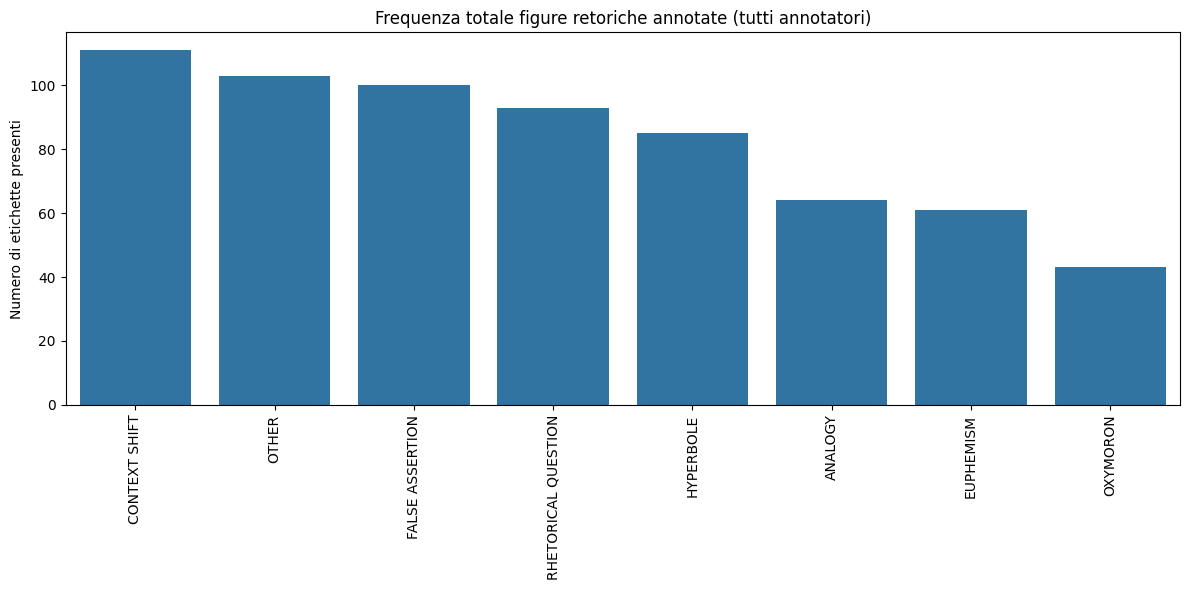

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# 2a) Distribuzione totale figure retoriche (somma su tutti annotatori)
total_counts = {fig: 0 for fig in figures}
for annotator in all_annotators:
    df = final_cleaned[annotator]
    for fig in figures:
        total_counts[fig] += df[fig].sum()

# Ordina per frequenza decrescente
sorted_counts = dict(sorted(total_counts.items(), key=lambda x: x[1], reverse=True))

plt.figure(figsize=(12,6))
sns.barplot(x=list(sorted_counts.keys()), y=list(sorted_counts.values()))
plt.xticks(rotation=90)
plt.title("Frequenza totale figure retoriche annotate (tutti annotatori)")
plt.ylabel("Numero di etichette presenti")
plt.tight_layout()
plt.show()


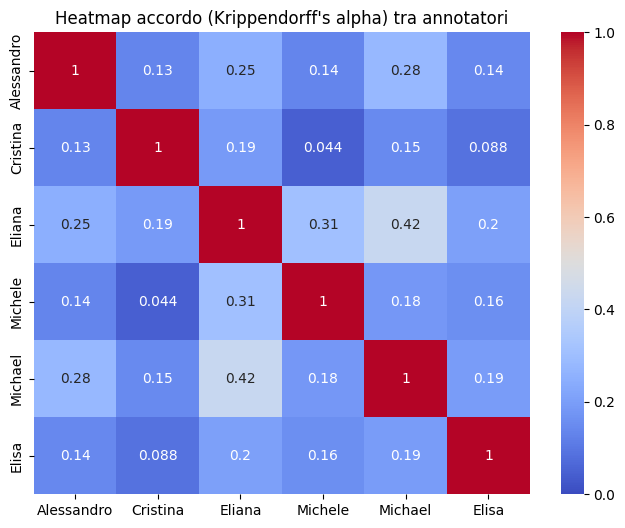

In [22]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import simpledorff  # Assumi che sia installato e importabile

def calc_kripp_for_pair(df1, df2, figures):
    alphas = []
    # Trova unità comuni (post_id, reply_id)
    units1 = set(zip(df1['post_id'], df1['reply_id']))
    units2 = set(zip(df2['post_id'], df2['reply_id']))
    common_units = units1.intersection(units2)
    if len(common_units) == 0:
        return np.nan

    for fig in figures:
        rows = []
        for unit in common_units:
            val1 = df1[(df1['post_id'] == unit[0]) & (df1['reply_id'] == unit[1])][fig].values
            val2 = df2[(df2['post_id'] == unit[0]) & (df2['reply_id'] == unit[1])][fig].values
            if len(val1) == 0 or len(val2) == 0:
                continue
            rows.append([unit, 'annotator1', val1[0]])
            rows.append([unit, 'annotator2', val2[0]])

        if len(rows) == 0:
            continue

        df_for_alpha = pd.DataFrame(rows, columns=['unit_id', 'annotator_id', 'Annotation'])

        unique_values = df_for_alpha['Annotation'].dropna().unique()
        if len(unique_values) <= 1:
            continue

        try:
            alpha = simpledorff.calculate_krippendorffs_alpha_for_df(
                df_for_alpha,
                experiment_col='unit_id',
                annotator_col='annotator_id',
                class_col='Annotation'
            )
            alphas.append(alpha)
        except ZeroDivisionError:
            continue

    if alphas:
        return np.mean(alphas)
    else:
        return np.nan

annotators = list(final_cleaned.keys())
figures = all_figures

# Inizializza matrice vuota
alpha_matrix = pd.DataFrame(index=annotators, columns=annotators, dtype=float)

for i, ann1 in enumerate(annotators):
    for j, ann2 in enumerate(annotators):
        if i == j:
            alpha_matrix.loc[ann1, ann2] = 1.0  # accordo perfetto
        elif pd.isna(alpha_matrix.loc[ann1, ann2]):
            df1 = final_cleaned[ann1]
            df2 = final_cleaned[ann2]

            alpha = calc_kripp_for_pair(df1, df2, figures)

            alpha_matrix.loc[ann1, ann2] = alpha
            alpha_matrix.loc[ann2, ann1] = alpha  # simmetrico

plt.figure(figsize=(8,6))
sns.heatmap(alpha_matrix, annot=True, cmap='coolwarm', vmin=0, vmax=1)
plt.title("Heatmap accordo (Krippendorff's alpha) tra annotatori")
plt.show()


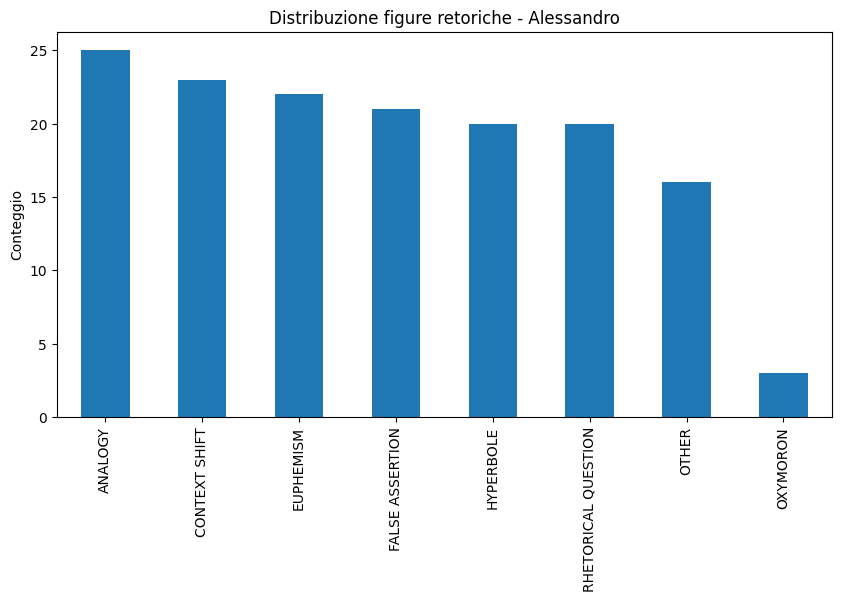

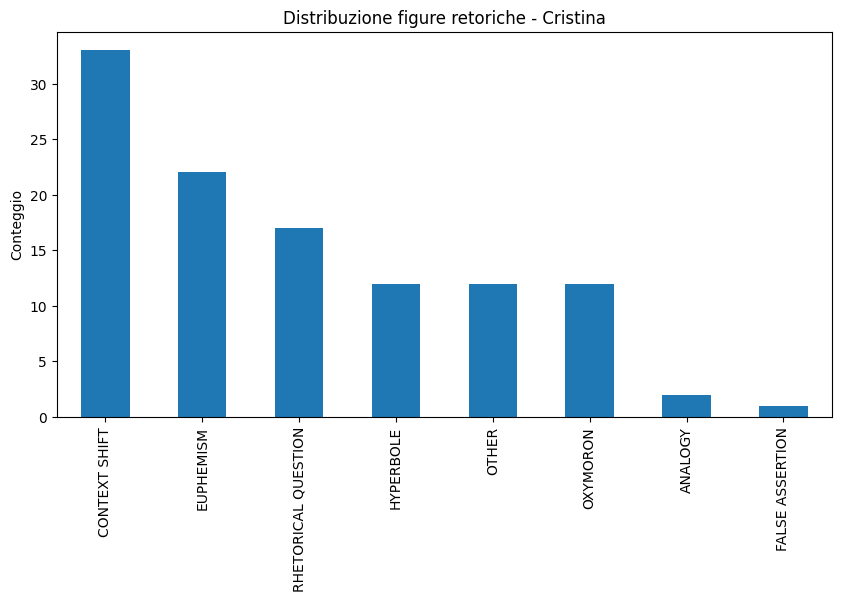

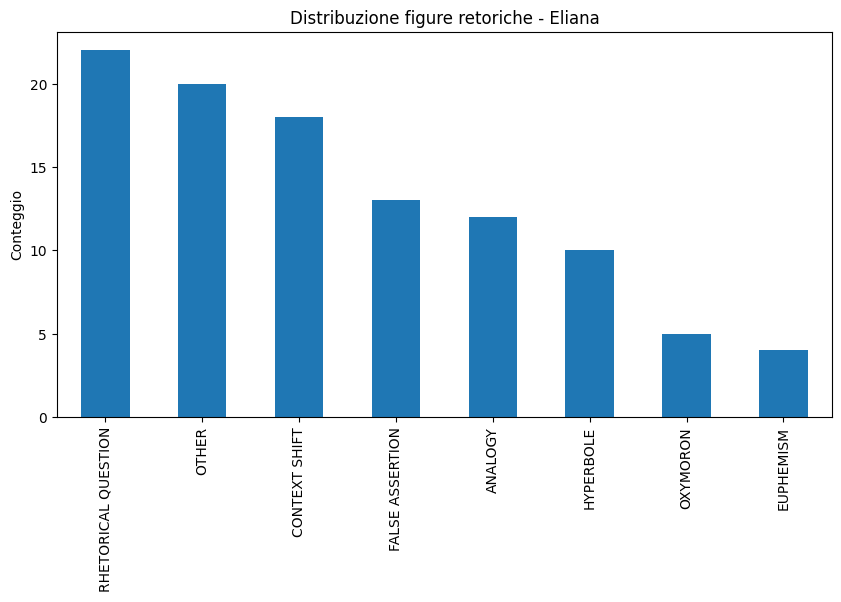

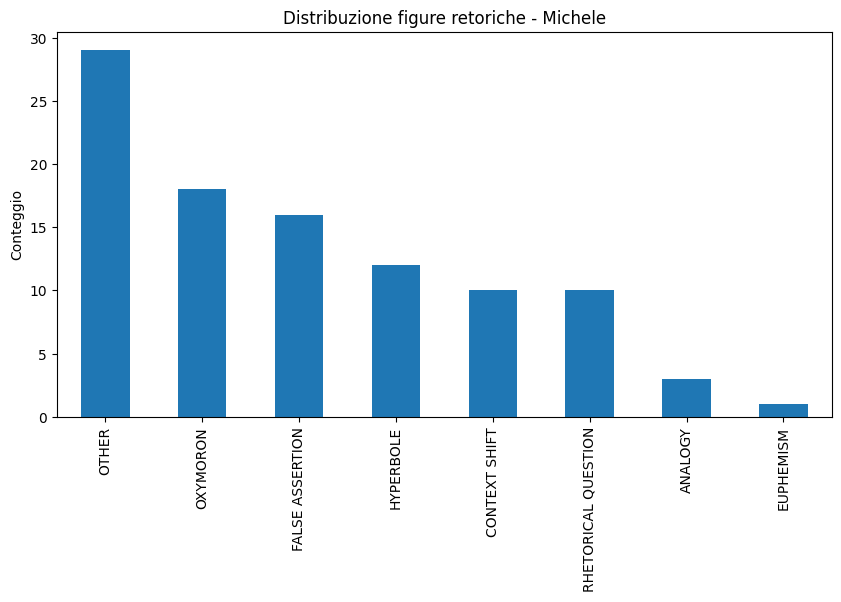

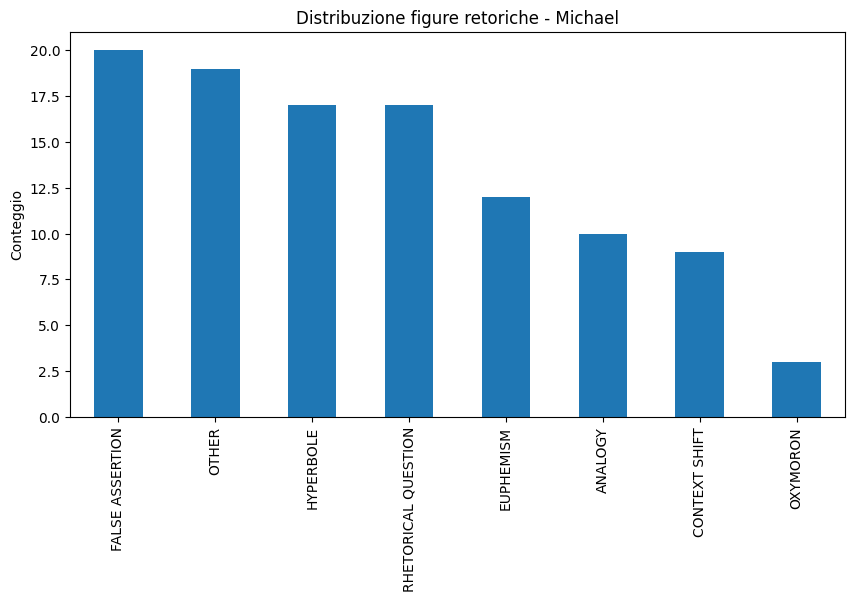

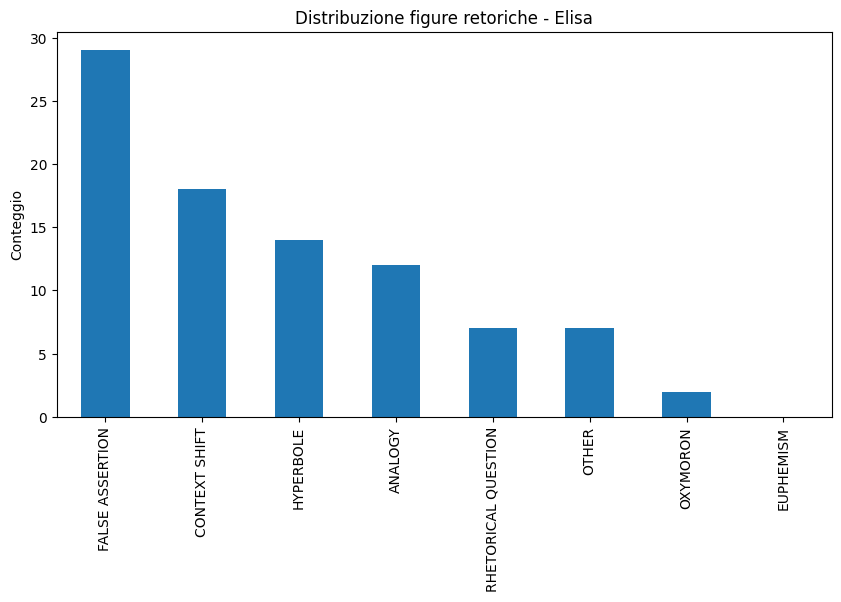

In [23]:
import matplotlib.pyplot as plt

for annotator in annotators:
    counts = final_cleaned[annotator][all_figures].sum().sort_values(ascending=False)
    plt.figure(figsize=(10,5))
    counts.plot(kind='bar')
    plt.title(f"Distribuzione figure retoriche - {annotator}")
    plt.ylabel("Conteggio")
    plt.show()


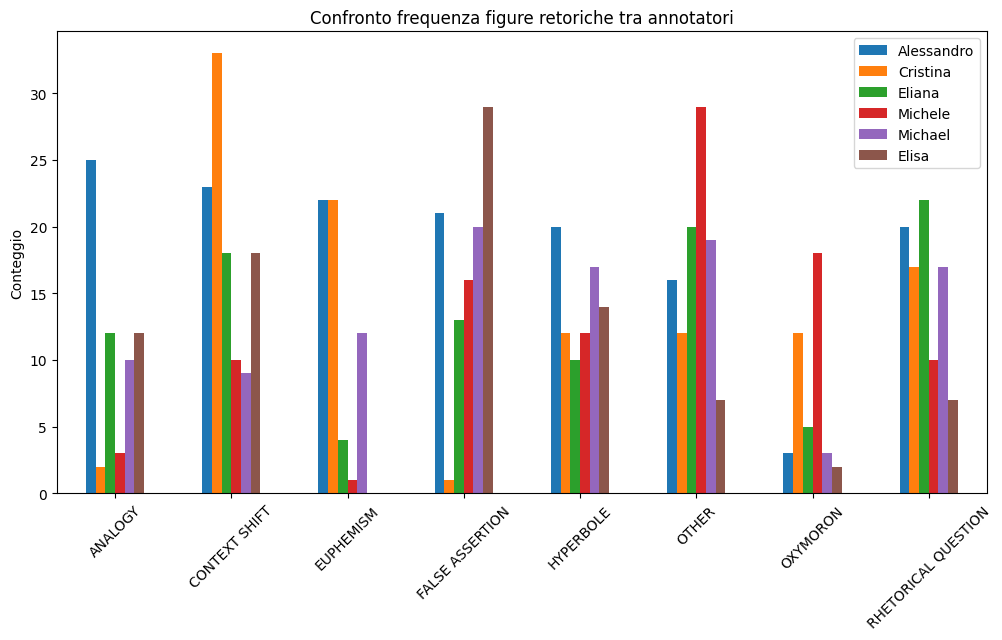

In [24]:
counts_df = pd.DataFrame({ann: final_cleaned[ann][all_figures].sum() for ann in annotators})
counts_df.plot(kind='bar', figsize=(12,6))
plt.title("Confronto frequenza figure retoriche tra annotatori")
plt.ylabel("Conteggio")
plt.xticks(rotation=45)
plt.show()


# Polarization index

⚖️ Differenza chiave
🟢 chi2_contingency
Serve per testare l’indipendenza tra due variabili categoriali in una tabella di contingenza (tipo annotatori × categorie).

È adatto per dati discreti organizzati come annotazioni multiple su categorie comuni.

✅ Adatto per il tuo caso, dove ogni annotatore assegna 1 o più categorie retoriche (riga = annotatore, colonna = figura, valori = 0 o 1).

🔴 chisquare
È un test unidimensionale, usato per confrontare una distribuzione osservata con una attesa teorica.

Presuppone una sola serie di frequenze osservate.

❌ Non è adatto per tabelle n annotatori × n categorie, come nel tuo group_df.


#### nota:
0 → massima coerenza (tutti d’accordo, nessuna polarizzazione)

1 → massima polarizzazione (gruppi coerenti internamente ma in disaccordo tra loro)

## Funzioni

In [67]:
from scipy.stats import chi2_contingency

def compute_agreement(group_df):
    contingency = group_df.drop(columns=['post_id', 'reply_id', 'annotator']).T

    # Rimuove righe e colonne a somma 0
    contingency = contingency.loc[~(contingency == 0).all(axis=1)]
    contingency = contingency.loc[:, ~(contingency == 0).all(axis=0)]

    if contingency.shape[0] < 2 or contingency.shape[1] < 2:
        return 0

    try:
        chi2, _, _, _ = chi2_contingency(contingency.values)
        aG = 1 - chi2 / len(group_df)
        return max(0, min(aG, 1))  # forza in [0, 1] --> SPIEGARE IL MOTIVO
    except ValueError:
        return 0

def compute_p_index(instance_df, group_map):
    k = len(set(group_map.values()))
    aG = compute_agreement(instance_df)

    group_agreements = []

    for group in set(group_map.values()):
        annotators_in_group = [a for a, g in group_map.items() if g == group]
        group_df = instance_df[instance_df['annotator'].isin(annotators_in_group)]
        aGw = compute_agreement(group_df)
        group_agreements.append(aGw * (1 - aG))
    
    return sum(group_agreements) / k


## Polarization su generazione

### Real

In [78]:
# from scipy.stats import chisquare

# Esempio: gruppi per GENERE (ipotetico, va adattato ai tuoi dati reali)
annotator_groups = {
    'Alessandro': 'genX',
    'Michele': 'genY',
    'Michael': 'genZ',
    'Cristina': 'genX',
    'Eliana': 'genY',
    'Elisa': 'genZ'
}

# Crea dataframe con annotazioni binarie per ogni figura
all_annotations = []
for annotator, df_ann in final_cleaned.items():
    df_copy = df_ann.copy()
    df_copy['annotator'] = annotator
    all_annotations.append(df_copy[['post_id', 'reply_id', 'annotator'] + all_figures])

full_df = pd.concat(all_annotations, ignore_index=True)
full_df.head()

p_index_per_instance = {}

group_map = annotator_groups  # come definito sopra
before = full_df[['post_id', 'reply_id']].shape[0]
instances = full_df[['post_id', 'reply_id']].drop_duplicates()

print(f"Numero totale di annotazioni: {before}")
print(f"Numero di istanze uniche (post_id, reply_id): {instances.shape[0]}")
print(f"Duplicati rimossi: {before - instances.shape[0]}")

for _, row in instances.iterrows():
    pid, rid = row['post_id'], row['reply_id']
    instance_df = full_df[(full_df['post_id'] == pid) & (full_df['reply_id'] == rid)]

    #if len(instance_df) < 2:
    #    continue  # troppo pochi annotatori per calcolare
    
    p_index = compute_p_index(instance_df, group_map)
    p_index_per_instance[(pid, rid)] = p_index

mean_p_index_real = sum(p_index_per_instance.values()) / len(p_index_per_instance)
print(f"Media del P-index per tutti i post: {mean_p_index_real:.3f}")

Numero totale di annotazioni: 492
Numero di istanze uniche (post_id, reply_id): 82
Duplicati rimossi: 410
Media del P-index per tutti i post: 0.520


### su coppie casuali (insieme delle parti)

In [79]:
import itertools
import pandas as pd

annotators = list(final_cleaned.keys())

# Dimensioni gruppi (esempio: metà e metà)
group1_size = len(annotators) // 3
group2_size = len(annotators) - group1_size

# Tutte le combinazioni possibili per il gruppo1
all_combinations = list(itertools.combinations(annotators, group1_size))
print(all_combinations)

print(f"Numero totale combinazioni: {len(all_combinations)}")

# Prepara il dataframe completo come prima
all_annotations = []
for annotator, df_ann in final_cleaned.items():
    df_copy = df_ann.copy()
    df_copy['annotator'] = annotator
    all_annotations.append(df_copy[['post_id', 'reply_id', 'annotator'] + all_figures])

full_df = pd.concat(all_annotations, ignore_index=True)
instances = full_df[['post_id', 'reply_id']].drop_duplicates()

p_index_means = []

for i, group1 in enumerate(all_combinations, 1):
    group2 = [a for a in annotators if a not in group1]
    group_map = {a: 'group1' if a in group1 else 'group2' for a in annotators}
    
    p_index_per_instance = {}
    
    for _, row in instances.iterrows():
        pid, rid = row['post_id'], row['reply_id']
        instance_df = full_df[(full_df['post_id'] == pid) & (full_df['reply_id'] == rid)]
        
        p_index = compute_p_index(instance_df, group_map)
        p_index_per_instance[(pid, rid)] = p_index
    
    mean_p_index = sum(p_index_per_instance.values()) / len(p_index_per_instance)
    p_index_means.append(mean_p_index)

    if i % 10 == 0 or i == len(all_combinations):
        print(f"Calcolate {i}/{len(all_combinations)} combinazioni, ultima media P-index: {mean_p_index:.3f}")

# Statistiche finali
overall_mean_random = sum(p_index_means) / len(p_index_means)
print(f"\nMedia del P-index su tutte le permutazioni: {overall_mean_random:.3f}")


[('Alessandro', 'Cristina'), ('Alessandro', 'Eliana'), ('Alessandro', 'Michele'), ('Alessandro', 'Michael'), ('Alessandro', 'Elisa'), ('Cristina', 'Eliana'), ('Cristina', 'Michele'), ('Cristina', 'Michael'), ('Cristina', 'Elisa'), ('Eliana', 'Michele'), ('Eliana', 'Michael'), ('Eliana', 'Elisa'), ('Michele', 'Michael'), ('Michele', 'Elisa'), ('Michael', 'Elisa')]
Numero totale combinazioni: 15
Calcolate 10/15 combinazioni, ultima media P-index: 0.233
Calcolate 15/15 combinazioni, ultima media P-index: 0.372

Media del P-index su tutte le permutazioni: 0.283


### Delta

In [81]:
def calc_delta(real, random):
    return ((real - random) / random) * 100

print("\nDelta tra P-index reale e medio casuale:")
print(f"  Reale: {mean_p_index_real:.3f}")
print(f"  Casual: {overall_mean_random:.3f}")

print(calc_delta(mean_p_index_real, overall_mean_random))


Delta tra P-index reale e medio casuale:
  Reale: 0.520
  Casual: 0.283
83.55308433199772


## Polarization su genere

### Real

In [82]:
# from scipy.stats import chisquare

# Esempio: gruppi per GENERE (ipotetico, va adattato ai tuoi dati reali)
annotator_groups = {
    'Alessandro': 'male',
    'Michele': 'male',
    'Michael': 'male',
    'Cristina': 'female',
    'Eliana': 'female',
    'Elisa': 'female'
}

# Crea dataframe con annotazioni binarie per ogni figura
all_annotations = []
for annotator, df_ann in final_cleaned.items():
    df_copy = df_ann.copy()
    df_copy['annotator'] = annotator
    all_annotations.append(df_copy[['post_id', 'reply_id', 'annotator'] + all_figures])

full_df = pd.concat(all_annotations, ignore_index=True)
full_df.head()

p_index_per_instance = {}

group_map = annotator_groups  # come definito sopra
before = full_df[['post_id', 'reply_id']].shape[0]
instances = full_df[['post_id', 'reply_id']].drop_duplicates()

print(f"Numero totale di annotazioni: {before}")
print(f"Numero di istanze uniche (post_id, reply_id): {instances.shape[0]}")
print(f"Duplicati rimossi: {before - instances.shape[0]}")

for _, row in instances.iterrows():
    pid, rid = row['post_id'], row['reply_id']
    instance_df = full_df[(full_df['post_id'] == pid) & (full_df['reply_id'] == rid)]

    #if len(instance_df) < 2:
    #    continue  # troppo pochi annotatori per calcolare
    
    p_index = compute_p_index(instance_df, group_map)
    p_index_per_instance[(pid, rid)] = p_index

mean_p_index_real = sum(p_index_per_instance.values()) / len(p_index_per_instance)
print(f"Media del P-index per tutti i post: {mean_p_index_real:.3f}")

Numero totale di annotazioni: 492
Numero di istanze uniche (post_id, reply_id): 82
Duplicati rimossi: 410
Media del P-index per tutti i post: 0.062


### su triple (insieme delle parti)

In [83]:
import itertools
import pandas as pd

annotators = list(final_cleaned.keys())

# Dimensioni gruppi (esempio: metà e metà)
group1_size = len(annotators) // 2
group2_size = len(annotators) - group1_size

# Tutte le combinazioni possibili per il gruppo1
all_combinations = list(itertools.combinations(annotators, group1_size))
print(all_combinations)

print(f"Numero totale combinazioni: {len(all_combinations)}")

# Prepara il dataframe completo come prima
all_annotations = []
for annotator, df_ann in final_cleaned.items():
    df_copy = df_ann.copy()
    df_copy['annotator'] = annotator
    all_annotations.append(df_copy[['post_id', 'reply_id', 'annotator'] + all_figures])

full_df = pd.concat(all_annotations, ignore_index=True)
instances = full_df[['post_id', 'reply_id']].drop_duplicates()

p_index_means = []

for i, group1 in enumerate(all_combinations, 1):
    group2 = [a for a in annotators if a not in group1]
    group_map = {a: 'group1' if a in group1 else 'group2' for a in annotators}
    
    p_index_per_instance = {}
    
    for _, row in instances.iterrows():
        pid, rid = row['post_id'], row['reply_id']
        instance_df = full_df[(full_df['post_id'] == pid) & (full_df['reply_id'] == rid)]
        
        p_index = compute_p_index(instance_df, group_map)
        p_index_per_instance[(pid, rid)] = p_index
    
    mean_p_index = sum(p_index_per_instance.values()) / len(p_index_per_instance)
    p_index_means.append(mean_p_index)

    if i % 10 == 0 or i == len(all_combinations):
        print(f"Calcolate {i}/{len(all_combinations)} combinazioni, ultima media P-index: {mean_p_index:.3f}")

# Statistiche finali
overall_mean_random = sum(p_index_means) / len(p_index_means)
print(f"\nMedia del P-index su tutte le permutazioni: {overall_mean_random:.3f}")


[('Alessandro', 'Cristina', 'Eliana'), ('Alessandro', 'Cristina', 'Michele'), ('Alessandro', 'Cristina', 'Michael'), ('Alessandro', 'Cristina', 'Elisa'), ('Alessandro', 'Eliana', 'Michele'), ('Alessandro', 'Eliana', 'Michael'), ('Alessandro', 'Eliana', 'Elisa'), ('Alessandro', 'Michele', 'Michael'), ('Alessandro', 'Michele', 'Elisa'), ('Alessandro', 'Michael', 'Elisa'), ('Cristina', 'Eliana', 'Michele'), ('Cristina', 'Eliana', 'Michael'), ('Cristina', 'Eliana', 'Elisa'), ('Cristina', 'Michele', 'Michael'), ('Cristina', 'Michele', 'Elisa'), ('Cristina', 'Michael', 'Elisa'), ('Eliana', 'Michele', 'Michael'), ('Eliana', 'Michele', 'Elisa'), ('Eliana', 'Michael', 'Elisa'), ('Michele', 'Michael', 'Elisa')]
Numero totale combinazioni: 20
Calcolate 10/20 combinazioni, ultima media P-index: 0.075
Calcolate 20/20 combinazioni, ultima media P-index: 0.068

Media del P-index su tutte le permutazioni: 0.072


### Delta

In [84]:
def calc_delta(real, random):
    return ((real - random) / random) * 100

print("\nDelta tra P-index reale e medio casuale:")
print(f"  Reale: {mean_p_index_real:.3f}")
print(f"  Casual: {overall_mean_random:.3f}")

print(calc_delta(mean_p_index_real, overall_mean_random))


Delta tra P-index reale e medio casuale:
  Reale: 0.062
  Casual: 0.072
-14.485611285919711
